In [ ]:
import torch
import torchvision

In [ ]:
import numpy as np

In [ ]:
# data loader for batches

In [ ]:
from torchvision import transforms
transform = transforms.Compose([ # reinitialize dataset object
    transforms.ToTensor()
])

In [ ]:
# mnist = torchvision.datasets.MNIST('', download = True, transform = transform)
fashion = torchvision.datasets.FashionMNIST('', download = True, transform = transform)

100%|██████████| 26421880/26421880 [00:02<00:00, 11041138.43it/s]


Extracting FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209993.74it/s]


Extracting FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3939481.05it/s]


Extracting FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22306071.27it/s]

Extracting FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/raw



In [ ]:
data_loader = torch.utils.data.DataLoader(fashion,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=0)

In [ ]:
for b in data_loader:
  print(b[0].shape)
  break # outputs 4 images and 4 labels
  # b[0].shape is 4 by 1 by 28 by 28, if rgb, would be 4 by 3 by 28 by 28 but this is grayscale so there's only one pixel intensity (one channel)

torch.Size([64, 1, 28, 28])


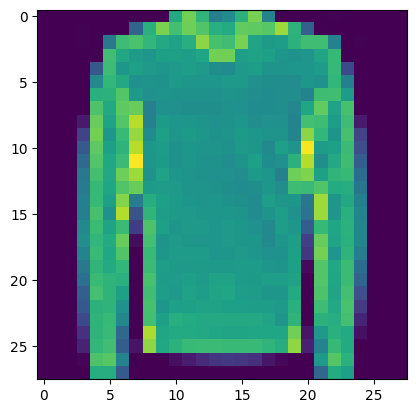

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(b[0][0].squeeze(0))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
data, labels = next(iter(data_loader)) # like printing b after for b in data_loader, this is a batch

In [ ]:
# 1 iteration

# optimizer = optim.AdamW(m.parameters())

# ce = nn.CrossEntropyLoss()

# m.train()
# optimizer.zero_grad()
# y_pred = m(data)
# loss = ce(y_pred, labels)

# loss.backward()
# optimizer.step()

In [ ]:
# testing data
test_data = torchvision.datasets.FashionMNIST('',
                           download=True,
                           train = False,
                           transform=transform)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=0)

In [ ]:
data, labels = next(iter(test_loader))

In [ ]:
def patchify(images, n_patches_per_row):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches_per_row ** 2, c * h * w // n_patches_per_row ** 2)
    patch_size = h // n_patches_per_row

    for idx, image in enumerate(images):
        for i in range(n_patches_per_row):
            for j in range(n_patches_per_row):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches_per_row + j] = patch.flatten()

    return patches


In [ ]:
class MLP(nn.Module):
  def __init__(self, embed_dim=16):
    super().__init__()
    self.up = nn.Linear(embed_dim, embed_dim*4)
    self.relu = nn.ReLU()
    self.down = nn.Linear(embed_dim*4, embed_dim)

  def forward(self, x):
    x = self.up(x)
    x = self.relu(x)
    x = self.down(x)
    return x

class Block(nn.Module):
  def __init__(self, embed_dim=16, num_heads=4):
    super().__init__()
    self.q = nn.Linear(embed_dim, embed_dim)
    self.k = nn.Linear(embed_dim, embed_dim)
    self.v = nn.Linear(embed_dim, embed_dim)

    self.mha = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
    self.mlp = MLP(embed_dim)

  def forward(self, x):
    q, k, v = self.q(x), self.k(x), self.v(x)
    attn_output, _ = self.mha(q, k, v)
    x = x + attn_output
    x = self.mlp(x)
    return x

In [ ]:
class VIT(nn.Module):
    def __init__(self, input_dim, output_dim, n_patches, hidden_d = 32, blocks=3, device="cuda"):
        super().__init__()

        self.chw = input_dim # (C, H, W) 1 x 28 x 28
        self.n_patches = n_patches
        self.hidden_d = hidden_d
        self.blocks = blocks
        self.device = device

        assert self.chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert self.chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (self.chw[1] / n_patches, self.chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(self.chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Adding Classification Token that is learned by our model
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional encoding
        self.pos_emb = nn.Embedding((n_patches**2)+1, self.hidden_d)

        self.blocks = nn.ModuleList([
            Block(self.hidden_d)
            for _ in range(self.blocks)
        ])

        self.classification_head = nn.Linear(self.hidden_d, output_dim)

    def patchify(self, images, n_patches_per_row):
      n, c, h, w = images.shape

      assert h == w, "Patchify method is implemented for square images only"

      patches = torch.zeros(n, n_patches_per_row ** 2, c * h * w // n_patches_per_row ** 2)
      patch_size = h // n_patches_per_row

      for idx, image in enumerate(images):
          for i in range(n_patches_per_row):
              for j in range(n_patches_per_row):
                  patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                  patches[idx, i * n_patches_per_row + j] = patch.flatten()

      return patches.to(self.device)

    def tokenize(self, x):
        patches = self.patchify(x, self.n_patches) # 4 x 49 x 16
        N, T, D = patches.shape
        # x = [batch size, height, width]

        tokens = self.linear_mapper(patches) # 4 x 49 x 8

        tokens = torch.cat([self.class_token.repeat(N, 1, 1), tokens], dim=1)
        # appended CLS token


        # expected shape: [4, 50, 16] = [N, T, D]

        pos_embed = self.pos_emb(torch.arange(0,T+1).to(self.device)) # shape: [50, 16]
        pos_embed = pos_embed.unsqueeze(0).repeat(N, 1, 1)

        tokens += pos_embed

        return tokens

    def forward(self, x): # b x c x h x w - batch size x 1 x 28 x 28, turn into output:
        # sequence of embeddings for each batch, b x s x d, s is # patches, d is dimensionality
        # batch size x 49 x dimension of embeddings
        x = self.tokenize(x)
        for block in self.blocks:
          x = block(x)

        cls_tokens = x[:, 0, :] # shape [N, 1, D]
        # cls_tokens = cls_tokens.squeeze(1) # shape [N, D]
        out = self.classification_head(cls_tokens)
        return out

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = VIT(
    input_dim=(1, 28, 28), output_dim=10, n_patches=7, hidden_d=16, blocks=2, device=device
)

model = model.to(device)

In [ ]:

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
ce = nn.CrossEntropyLoss()

In [ ]:
losses = []

model.train() # puts in training mode

epochs = 20
for epoch in range(epochs):
  for idx, (data, labels) in enumerate(data_loader):

    data = data.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = ce(y_pred, labels)
    losses.append(loss)
    if idx%10==0:
      print(f'step: {idx}, avg loss: {sum(losses)/len(losses)}')

    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch}, Loss: {loss}")


step: 0, avg loss: 0.47764408588409424
step: 10, avg loss: 0.36712646484375
step: 20, avg loss: 0.3709166646003723
step: 30, avg loss: 0.36942315101623535
step: 40, avg loss: 0.36005908250808716
step: 50, avg loss: 0.36497437953948975
step: 60, avg loss: 0.36181315779685974
step: 70, avg loss: 0.3580978214740753
step: 80, avg loss: 0.3555697798728943
step: 90, avg loss: 0.355264276266098
step: 100, avg loss: 0.3557531237602234
step: 110, avg loss: 0.3555779457092285
step: 120, avg loss: 0.35670721530914307
step: 130, avg loss: 0.35922592878341675
step: 140, avg loss: 0.35943907499313354
step: 150, avg loss: 0.3590947687625885
step: 160, avg loss: 0.359125018119812
step: 170, avg loss: 0.35981473326683044
step: 180, avg loss: 0.3560330867767334
step: 190, avg loss: 0.35773733258247375
step: 200, avg loss: 0.3562139868736267
step: 210, avg loss: 0.35689789056777954
step: 220, avg loss: 0.3576526641845703
step: 230, avg loss: 0.3584369122982025
step: 240, avg loss: 0.3588406443595886
step

In [ ]:
torch.save(model.state_dict(), 'fashion_weights.pth')

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
ce = nn.CrossEntropyLoss()

In [ ]:
losses = []

model.train() # puts in training mode

epochs = 10
for epoch in range(epochs):
  for idx, (data, labels) in enumerate(data_loader):

    data = data.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = ce(y_pred, labels)
    losses.append(loss)
    if idx%10==0:
      print(f'step: {idx}, avg loss: {sum(losses)/len(losses)}')

    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch}, Loss: {losses}")


step: 0, avg loss: 0.020251065492630005
step: 10, avg loss: 0.05923197790980339
step: 20, avg loss: 0.07284872233867645
step: 30, avg loss: 0.06453749537467957
step: 40, avg loss: 0.06585352122783661
step: 50, avg loss: 0.06361444294452667
step: 60, avg loss: 0.06213159114122391
step: 70, avg loss: 0.059320852160453796
step: 80, avg loss: 0.05887885019183159
step: 90, avg loss: 0.06294993311166763
step: 100, avg loss: 0.06183387711644173
step: 110, avg loss: 0.06283870339393616
step: 120, avg loss: 0.06234157457947731
step: 130, avg loss: 0.06348378956317902
step: 140, avg loss: 0.061773113906383514
step: 150, avg loss: 0.06238425150513649
step: 160, avg loss: 0.06214863434433937
step: 170, avg loss: 0.06205109879374504
step: 180, avg loss: 0.06337140500545502
step: 190, avg loss: 0.06302379816770554
step: 200, avg loss: 0.0628521591424942
step: 210, avg loss: 0.06273401528596878
step: 220, avg loss: 0.06467889249324799
step: 230, avg loss: 0.06644415855407715
step: 240, avg loss: 0.06

In [ ]:
all_predictions = []
all_labels = []

for idx, (data, labels) in enumerate(test_loader):
  data = data.to(device)
  labels = labels.to(device)
  with torch.no_grad():
    probabilities = model(data)
  predictions = torch.argmax(probabilities, axis=-1)
  true_labels = labels
  all_predictions.extend(predictions.cpu().numpy().tolist())
  all_labels.extend(labels.cpu().numpy().tolist())


In [ ]:
np.array([x == y for x, y in zip(all_predictions, all_labels)]).mean()

0.8581

In [ ]:
test_loader2 = torch.utils.data.DataLoader(test_data,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=0)

In [ ]:
preds = []
true_vals = []

# get logits (probs) get arg max
testing = 0

for idx, (data, labels) in enumerate(test_loader2):

  testing += 1

  data, labels = next(iter(test_loader2))

  data = data.to(device)
  labels = labels.to(device)


  true_vals.extend([x.item() for x in labels]) # save true labels
  with torch.no_grad():
    y_pred = model(data)
  predictions = torch.argmax(y_pred, dim=1).cpu().numpy().tolist()
  print(y_pred)
  preds.extend(predictions)

  if (testing == 10):
    break

tensor([[-13.4055,  -2.2401,   0.3599,   3.0609,  -6.6552,  -2.6494, -11.2363,
          14.3707,  -8.3445,  -1.5036]], device='cuda:0')
tensor([[ -9.1947,  -9.4884,   0.9642,  -0.8081,  15.9052,  -7.2205, -12.8137,
          -0.1363,   5.1376,   0.7924]], device='cuda:0')
tensor([[ -2.9974,  -6.3577,  -5.4367,  -3.0362, -14.5972,  21.3025,   1.9207,
          -1.9825,   1.3315,  -2.8173]], device='cuda:0')
tensor([[-1.3608e+00,  8.3606e+00,  8.9020e+00,  1.2330e+00, -3.7606e+00,
         -1.9400e-03, -1.7715e+00, -1.6100e+00, -3.9244e+00, -4.1737e+00]],
       device='cuda:0')
tensor([[-4.0228,  2.5955,  6.7100,  1.7453, -2.8404, -1.1635, -4.0296,  3.9424,
         -5.8765, -4.8133]], device='cuda:0')
tensor([[-0.1978,  0.8622, -1.1095,  1.0939, -3.5014, -2.6936, -3.7233,  0.3604,
          6.4418, -0.6223]], device='cuda:0')
tensor([[-1.5461, -2.4327,  0.6359, -3.3978, 12.2927, -3.0734,  0.0261, -1.2415,
         -4.8316,  6.1436]], device='cuda:0')
tensor([[-4.8383, -5.8807, -5.7596

In [ ]:
preds

[7, 4, 5, 2, 2, 8, 4, 4, 0, 6]

In [ ]:
true_vals

[7, 4, 5, 2, 2, 8, 4, 4, 0, 6]

In [ ]:
torch.save(model.state_dict(), 'evenbetterweights.pth')

In [ ]:
0torch.argmax(model(data), axis=1)

tensor([5, 5, 5, 5], device='cuda:0')

In [ ]:
print(data[0][0].shape)

torch.Size([28, 28])


In [ ]:
print(labels)

tensor([4, 9, 3, 8], device='cuda:0')


In [ ]:
labels

tensor([1, 0, 3, 4])

In [ ]:
num_samples = 0
num_correct = 0
for data, labels in test_loader:
  num_samples += len(labels)
  preds = torch.argmax(m(data), dim=-1)
  num_correct += sum(preds == labels)

num_correct/num_samples

tensor(0.1008)

In [ ]:
test_input = torch.randn(4, 1, 28, 28)
model(test_input).shape

torch.Size([4, 10])

In [ ]:
# create two sample vectors
N, T, D = 4, 49, 16
inps = test_sequence = torch.randn(N, T, D)
d_orig = test_embed = torch.randn(1, D).unsqueeze(0)
d_repeat = d_orig.repeat(N, 1, 1)

a = torch.cat([d_repeat, inps], dim=1)

## MLP Part

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
ce = nn.CrossEntropyLoss()

NameError: ignored

In [ ]:
import torch.optim as optim

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = VIT(
    input_dim=(1, 28, 28), output_dim=10, n_patches=7, hidden_d=16, blocks=2, device=device
)

model = model.to(device)

In [ ]:
a.shape

torch.Size([16, 197, 16])

In [ ]:
a[0,0,:]

tensor([-0.9394,  1.7848, -0.3612, -0.5182,  0.6462,  0.0430,  0.6311,  0.1861,
         0.0152,  0.2347,  1.8798, -0.9534, -1.2178, -1.0636, -0.5045, -0.1788])

In [ ]:
d_repeat[0,0]

tensor([-0.9394,  1.7848, -0.3612, -0.5182,  0.6462,  0.0430,  0.6311,  0.1861,
         0.0152,  0.2347,  1.8798, -0.9534, -1.2178, -1.0636, -0.5045, -0.1788])

In [ ]:
d_orig[0]

tensor([[-0.9394,  1.7848, -0.3612, -0.5182,  0.6462,  0.0430,  0.6311,  0.1861,
          0.0152,  0.2347,  1.8798, -0.9534, -1.2178, -1.0636, -0.5045, -0.1788]])

In [ ]:
test_sequence.shape

torch.Size([4, 49, 16])

In [ ]:
import einops

In [ ]:
patch = patchify(data, 4)

In [ ]:
patch_alyssa = patchify(data , 7)
patch_alyssa.shape

torch.Size([4, 49, 16])

In [ ]:
patch.shape

torch.Size([4, 49, 16])

In [ ]:
patch =

In [ ]:
patch.shape

torch.Size([4, 49, 16])